In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import Column, Integer, String, Float

In [5]:
# Connect to hawaii.sqlite database using sqlalchemy create_engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into ORM classes
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found - table names
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [15]:
# Get the latest date
MaxDate = engine.execute("SELECT MAX(date) FROM Measurement").fetchall()
EndDate = MaxDate[0][0]

Year = int(EndDate[0:4])
Month = int(EndDate[5:7])
Day = int(EndDate[8:])

StartDate = dt.date(Year, Month, Day) - dt.timedelta(days=365)
print(f"The last 12 months are from {StartDate} to {EndDate}")

The last 12 months are from 2016-08-23 to 2017-08-23


In [16]:
# Retrieve the last 12 months of precipitation data
prcp_data = session.query(Measurement.date,Measurement.prcp)\
                          .filter(Measurement.date <= EndDate)\
                          .filter(Measurement.date >= StartDate)\
                          .order_by(Measurement.date.desc()).all()
#for data in PRCP_data: 
#     print(data)

# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df = pd.DataFrame(prcp_data).rename(columns={"date":"Date","prcp":"Precipitation"})
prcp_df.set_index("Date",inplace=True)
prcp_df.head()

,Precipitation
Date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


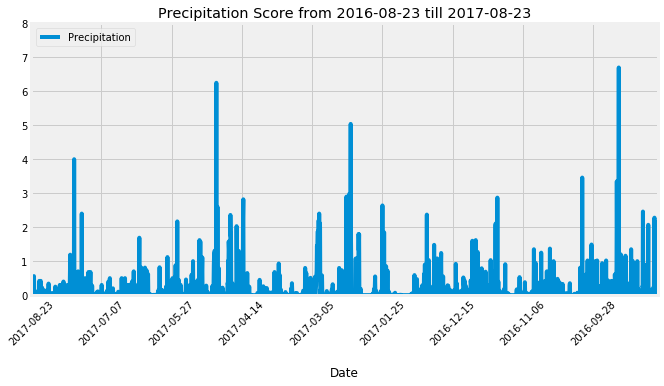

In [17]:
# Plot the results using the DataFrame plot method
prcp_df.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {StartDate} till {EndDate}',\
                  label="Precipitation",rot=45)
plt.legend(loc="upper left")
plt.xlabel("\nDate")
plt.savefig("Precipitation_Analysis.jpg")
plt.show()

In [18]:
# Use Pandas to print the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
Stations = session.query(Station).count()
print(f'Total number of stations is: {Stations}')

Total number of stations is: 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Stations_desc = session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).all()

#for station in Stations_desc: 
     #print(station)
        
print("Rank\t Station ID\t observation counts")
i = 1
for active_stations in Stations_desc:
    print("%d\t %s\t %d" %(i,active_stations[0],active_stations[1]))
    
    if i==1:
        station = active_stations[0]
        observation = active_stations[1]
    i+=1

print()
print(f"{station} station has the highest number of observations {observation}.")    

Rank	 Station ID	 observation counts
1	 USC00519281	 2772
2	 USC00519397	 2724
3	 USC00513117	 2709
4	 USC00519523	 2669
5	 USC00516128	 2612
6	 USC00514830	 2202
7	 USC00511918	 1979
8	 USC00517948	 1372
9	 USC00518838	 511

USC00519281 station has the highest number of observations 2772.


In [21]:
Stations_desc = session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).first()

Stations_desc[1]

2772

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Station = session.query(Measurement.station,func.count(Measurement.station))\
                                     .group_by(Measurement.station)\
                                     .order_by(func.count(Measurement.station).desc()).first()

Stations_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                  .filter(Measurement.station == Station[0]).all()

print(f"The most active station is {Station[0]} with its lowest temperature, highest temperature, and average temperature.")
print()
print("Lowest   Highest  Average")

for temp in Stations_temp:
    print("---------------------------")
    print(f"{round(temp[0],2)}     {round(temp[1],2)}     {round(temp[2],2)}")

The most active station is USC00519281 with its lowest temperature, highest temperature, and average temperature.

Lowest   Highest  Average
---------------------------
54.0     85.0     71.66


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Station_temp = session.query(Measurement.date,Measurement.tobs)\
             .filter(Measurement.date >= StartDate).filter(Measurement.date<=EndDate)\
             .filter(Measurement.station == Station[0]).order_by(Measurement.date.desc()).all()

#for temp in Station_temp:
    #print(temp)
    
# Use Pandas to calcualte the summary statistics for the precipitation data
temp_df = pd.DataFrame(Station_temp).rename(columns={"date":"Date","tobs":"Temperature"})
temp_df.set_index("Date",inplace=True)
temp_df.head()    

,Temperature
Date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0


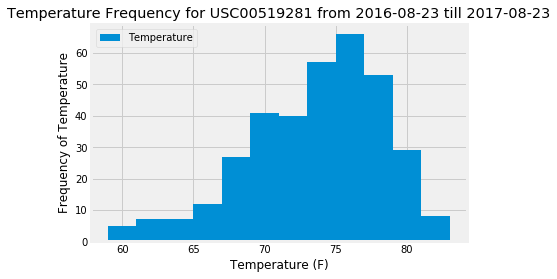

In [24]:
# Plot the results using the DataFrame plot method
temp_df.plot.hist(by="Temperature",bins=12,label="tobs",title=f'Temperature Frequency for {Station[0]} from {StartDate} till {EndDate}')
plt.ylim=(0,80)
plt.ylabel("Frequency of Temperature")
plt.xlabel("Temperature (F)")
plt.legend=()
plt.savefig("Temperature_Analysis.jpg")
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [26]:
start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ")
end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ")

Enter the trip start date in 'YYYY-MM-DD' format: 2017-01-01
Enter the trip end date in 'YYYY-MM-DD' format: 2017-01-10


In [27]:
#print(calc_temps(start_date, end_date))
t = calc_temps(start_date, end_date)

print(f"The lowest, highest and average temperatures for the trip between {start_date} and {end_date}.")
print()
print("Lowest   Highest  Average")

for temp in Stations_temp:
    print("---------------------------")
    print(f"{round(t[0][0],2)}     {round(t[0][1],2)}     {round(t[0][2],2)}")

The lowest, highest and average temperatures for the trip between 2017-01-01 and 2017-01-10.

Lowest   Highest  Average
---------------------------
60.0     68.03     77.0


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_start_date = start_date
Trip_end_date = end_date

Year = int(start_date[0:4])
Month = int(start_date[5:7])
Day = int(start_date[8:])
prev_start_date = dt.date(Year, Month, Day) - dt.timedelta(days=365)

Year = int(end_date[0:4])
Month = int(end_date[5:7])
Day = int(end_date[8:])
prev_end_date = dt.date(Year, Month, Day) - dt.timedelta(days=365)

t = calc_temps(prev_start_date, prev_end_date)

print(f"The lowest, highest and average temperatures for the previous trip between {prev_start_date} and {prev_end_date}.")
print()
print("Lowest   Highest  Average")

for temp in Stations_temp:
    print("---------------------------")
    print(f"{round(t[0][0],2)}     {round(t[0][1],2)}     {round(t[0][2],2)}")

The lowest, highest and average temperatures for the previous trip between 2016-01-02 and 2016-01-11.

Lowest   Highest  Average
---------------------------
62.0     70.41     78.0


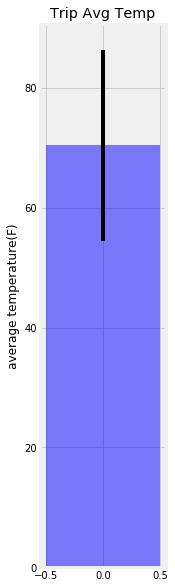

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = t[0][0]
tavg = t[0][1]
tmax = t[0][2]
yerr = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg,yerr=yerr,align="center",width=1,color="blue",alpha=0.5)
plt.ylim=(0,100)
plt.ylabel("average temperature(F)")
plt.title("Trip Avg Temp")
plt.savefig("Trip_Avg_Temp.jpg")
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

rainfall = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .filter(Measurement.date>=prev_start_date).filter(Measurement.date<=prev_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()  

print("Station \t Total Rainfall")
print("--------------------------------")

for (s, r) in rainfall: 
    print(s,"\t",round(r,2))

Station 	 Total Rainfall
--------------------------------
USC00516128 	 2.94
USC00519281 	 0.97
USC00513117 	 0.56
USC00519397 	 0.23
USC00514830 	 0.22
USC00519523 	 0.13
USC00517948 	 0.0


In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sql_string = [Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]

results = session.query(*sql_string).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=prev_start_date).filter(Measurement.date<=prev_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

print("Station \t Name \t\t\t\t\t  Latitude \t Longitude \t Elevation \t Rainfall")
print("------------------------------------------------------------------------------------------------------------------")

for (s,n,la,lo,el,r) in results: 
    print(s,"\t","{:<40}".format(n),la,"\t",round(lo,2),"\t",el,"\t\t",round(r,2))

Station 	 Name 					  Latitude 	 Longitude 	 Elevation 	 Rainfall
------------------------------------------------------------------------------------------------------------------
USC00516128 	 MANOA LYON ARBO 785.2, HI US             21.3331 	 -157.8 	 152.4 		 2.94
USC00519281 	 WAIHEE 837.5, HI US                      21.45167 	 -157.85 	 32.9 		 0.97
USC00513117 	 KANEOHE 838.1, HI US                     21.4234 	 -157.8 	 14.6 		 0.56
USC00519397 	 WAIKIKI 717.2, HI US                     21.2716 	 -157.82 	 3.0 		 0.23
USC00514830 	 KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213 	 -157.84 	 7.0 		 0.22
USC00519523 	 WAIMANALO EXPERIMENTAL FARM, HI US       21.33556 	 -157.71 	 19.5 		 0.13
USC00517948 	 PEARL CITY, HI US                        21.3934 	 -157.98 	 11.9 		 0.0


## Optional Challenge Assignment

In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates


# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ")
end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ")

Enter the trip start date in 'YYYY-MM-DD' format: 2018-01-01
Enter the trip end date in 'YYYY-MM-DD' format: 2018-01-09


In [35]:
# Stip off the year and save a list of %m-%d strings
start_m_d = start_date[5:]
end_m_d = end_date[5:]

results = daily_normals(start_m_d)

for result in results:
    print(result)

(62.0, 69.15384615384616, 77.0)
